In [1]:
library(lmtest)
library(nlme)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




# Часть 1

In [2]:
generate_regression <- function(x, a, b, lambda){
    
    y <- rep(1,length(x))
    sigma <- rep(1,length(x))
    
    for (i in 2:length(x)){
        sigma[i] <- lambda * sigma[i-1] +  rnorm(1, mean = 0, sd = 1)
    }
    
    for (i in 1:length(x)){
        y[i] <- a + b * x[i] + sigma[i]
    }

    return ( y )
}


# generate_regression_ar1 <- function(x, a, b, lambda) {
#   n <- length(x)
#   epsilon <- rep(0, n)
  
#   for (i in 2:n) {
#     epsilon[i] <- lambda * epsilon[i - 1] + rnorm(1, mean = 0, sd = 1)
#   }

#   y <- a + b * x + epsilon

#   return(list(y = y, epsilon = epsilon))
# }

## Генерация выборки с корреляцией

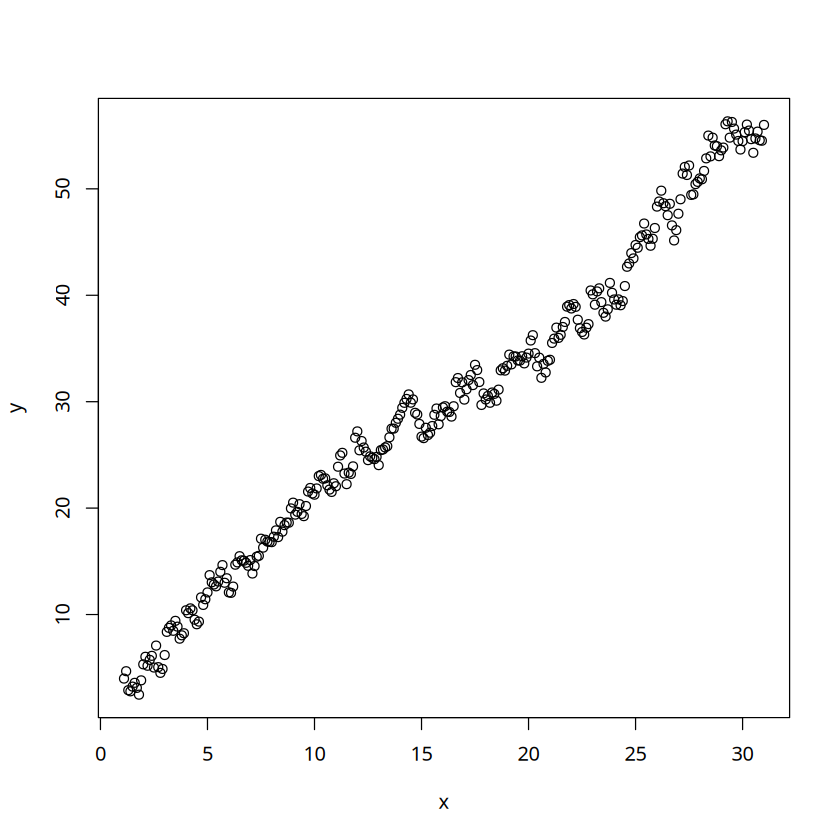

In [3]:
n <- 300
i <- 1:n
x <- 1 + 0.1 * i
y <- generate_regression(x, 1, 1.8, .9)
plot(x, y, type = "p") 

### тест Дарбина-Уотсона 

In [4]:
residuals <- lm(y~x)$residuals

n <- length(residuals)
sum_squared_diff <- sum(diff(residuals)^2)
sum_squared_residuals <- sum(residuals^2)
durbin_watson_statistic <- sum_squared_diff / sum_squared_residuals
durbin_watson_statistic

[1] 0.2293963

Проверю значение библиотечным тестом

In [5]:
dwtest(lm(y~x))


	Durbin-Watson test

data:  lm(y ~ x)
DW = 0.2294, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is greater than 0


### ДОМНК 

In [6]:
G <- diag(1,n)

X <- cbind(1, x)
teta <- solve(t(X)  %*% solve(G) %*% X) %*% t(X) %*% solve(G) %*% y
teta

# y_pred <- X %*% teta
# residuals <- y - y_pred

,2.942314
x,1.670409


**Вроде все правильно**

In [7]:
gls(y ~ x, correlation = corAR1())

Generalized least squares fit by REML
  Model: y ~ x 
  Data: NULL 
  Log-restricted-likelihood: -410.6829

Coefficients:
(Intercept)           x 
   2.783273    1.681137 

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.8958739 
Degrees of freedom: 300 total; 298 residual
Residual standard error: 2.130017 

## Гетероскедастичность

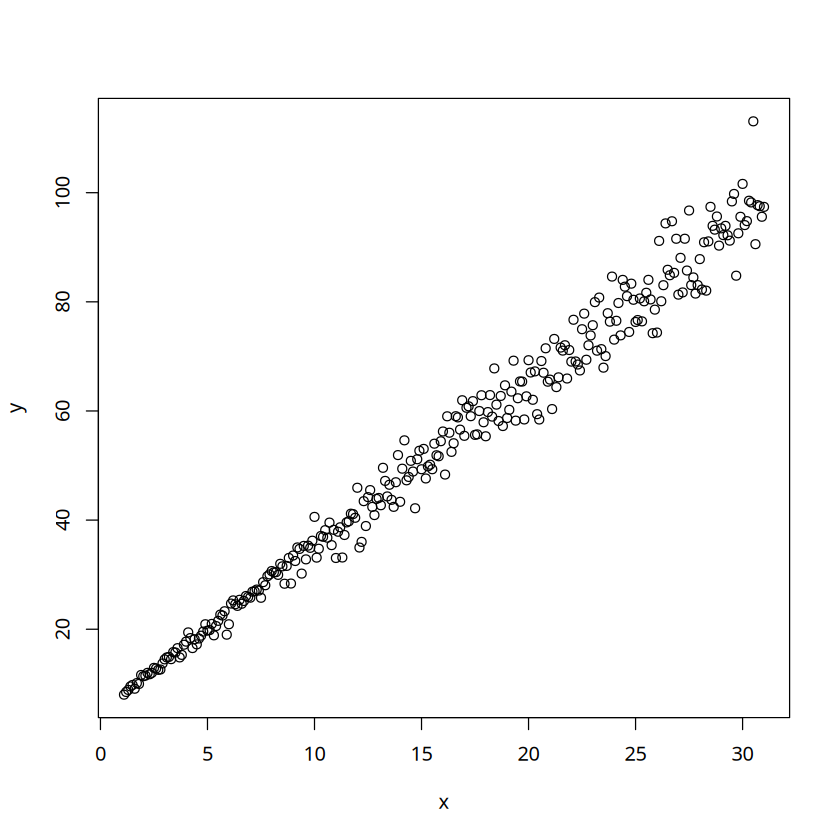

In [8]:
e <- x*rnorm(n,0,.2)
y <- 5+3*x+e
plot(y~x)

In [9]:
model <- summary(lm(y~x))

In [10]:
gqtest(model)


	Goldfeld-Quandt test

data:  model
GQ = 4.6316, df1 = 148, df2 = 148, p-value < 2.2e-16
alternative hypothesis: variance increases from segment 1 to 2


### ОМНК

In [11]:
G <- diag(c(x^2),n)

x0 = rep(1,n)
Y = matrix(c(y),n,1)
X = matrix(c(x0,x),n,2)

teta <- solve(t(X)%*%solve(G)%*%X)%*%t(X)%*%solve(G)%*%Y
teta

4.995856
3.009049


# Часть 2


Call:
lm(formula = Rent ~ M2, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-12529.4  -1374.1   -381.2    432.1  11110.5 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   7391.8     1335.5   5.535 1.28e-06 ***
M2             165.9       42.2   3.931 0.000271 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3474 on 48 degrees of freedom
Multiple R-squared:  0.2435,	Adjusted R-squared:  0.2278 
F-statistic: 15.45 on 1 and 48 DF,  p-value: 0.0002708


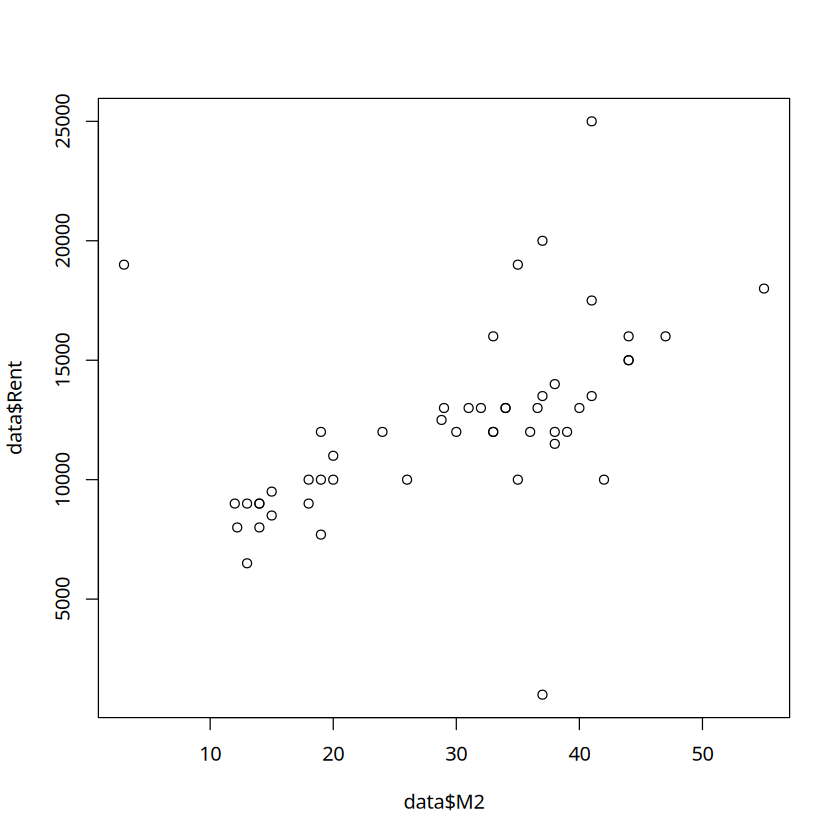

In [12]:
data <- read.table(file = "../Data/flats_1.txt", header = TRUE)
model <- lm(Rent ~ M2, data = data)
plot(data$M2  , data$Rent)
summary(model)

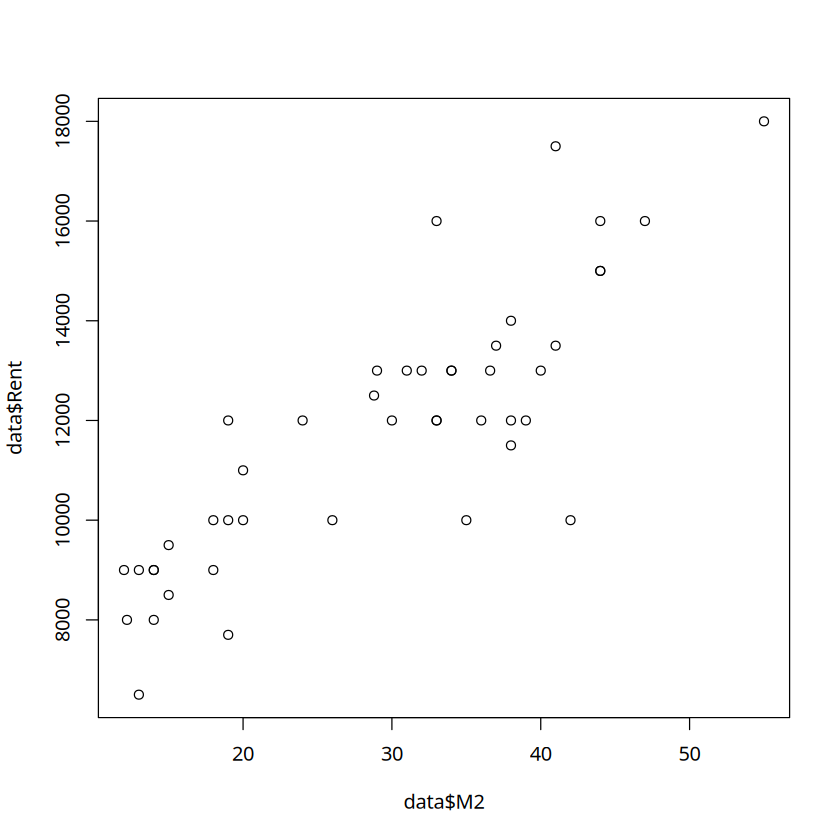

In [13]:
data <- data[-which(data$M2 == 3.0),]
data <- data[-which(data$Rent > 18999),]
data <- data[-which(data$Rent < 5000),]
plot(data$M2  , data$Rent)

In [14]:
model <- lm(Rent ~ M2, data = data)
shapiro.test(model$residuals)


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.95403, p-value = 0.07228


In [15]:
gqtest(model)


	Goldfeld-Quandt test

data:  model
GQ = 2.213, df1 = 21, df2 = 20, p-value = 0.04053
alternative hypothesis: variance increases from segment 1 to 2


Присутствует **гетероскедастичность**

In [16]:
dwtest(model)


	Durbin-Watson test

data:  model
DW = 1.7342, p-value = 0.1556
alternative hypothesis: true autocorrelation is greater than 0


```
y = data$Price / data$M2
x = 1/data$M2
```


Call:
lm(formula = (Rent/M2) ~ (1/M2), data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-205.44 -102.63  -38.27   82.78  306.46 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   443.54      18.67   23.76   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 125.2 on 44 degrees of freedom


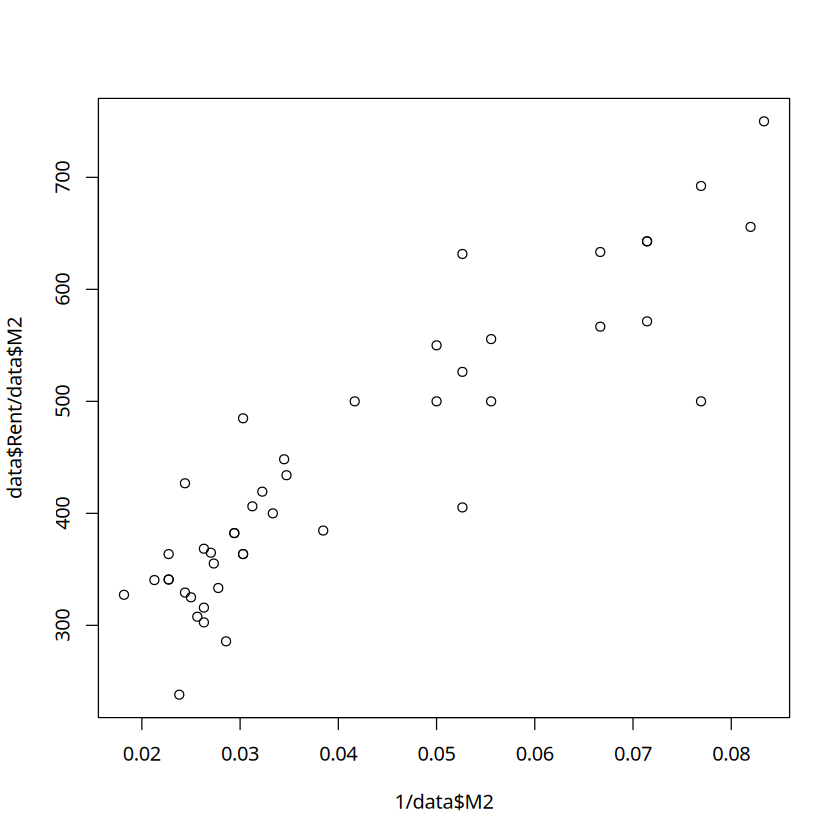

In [17]:
data <- data[ order(data$Rent), ]
model2 <- lm( (Rent / M2) ~ (1/M2) ,data = data)
summary(model2)
plot(1/data$M2  , data$Rent/data$M2)

In [18]:
shapiro.test(model2$residuals)


	Shapiro-Wilk normality test

data:  model2$residuals
W = 0.9286, p-value = 0.008371


In [19]:
gqtest(model2)


	Goldfeld-Quandt test

data:  model2
GQ = 0.11309, df1 = 22, df2 = 21, p-value = 1
alternative hypothesis: variance increases from segment 1 to 2


In [20]:
model2_begin <- lm( (Rent / M2) ~ (1/M2) ,data = head(data,30))
model2_end <- lm( (Rent / M2) ~ (1/M2) ,data = tail(data,30))
F <- var(model2_begin$residuals) / var(model2_end$residuals)
F

[1] 2.925459

In [21]:
alpha <- 0.05

DF1 <- 1
DF2 <- 59

critical_value <- qf(1 - alpha, DF1, DF2)
critical_value

[1] 4.003983